# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


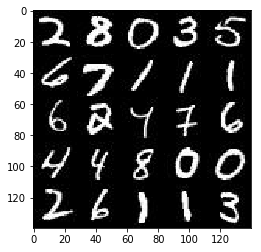

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

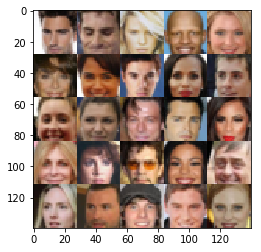

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
        
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="inputs_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="input_learning_rate")
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(alpha * x, x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28 x 28 x n_channels
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        lrelu1 = leaky_relu(x1)
        # 14x14x1024
        
        x2 = tf.layers.conv2d(lrelu1, 256, 4, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        lrelu2 = leaky_relu(bn2)
        # 7x7x256
        
        x3 = tf.layers.conv2d(lrelu2, 512, 3, strides=3, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        lrelu3 = leaky_relu(bn3)
        # 3x3x512

        # Flatten
        flat = tf.reshape(lrelu3, (-1, 3*3*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not(is_train)):

        x1 = tf.layers.dense(z, 2*2*512)
        
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        lrelu1 = leaky_relu(bn1)
        # 2 x 2 x 512
        
        # setting padding to 'valid' to be able to go from 2x2 to 7x7
        x2 = tf.layers.conv2d_transpose(lrelu1, 256, 5, strides=2, padding='valid')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        lrelu2 = leaky_relu(bn2)
        # 7 x 7 x 256
        
        x3 = tf.layers.conv2d_transpose(lrelu2, 128, 4, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        lrelu3 = leaky_relu(bn3)
        # 14 x 14 x 128
        
        
        x4 = tf.layers.conv2d_transpose(lrelu3, 64, 4, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        lrelu4 = leaky_relu(bn4)
        # 28 x 28 x 64
        
        # Output layer
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 1, strides=1, padding='same')
        # 28 x 28 x out_channel_dim
        
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [45]:
import random

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # I've tried to implement label smoothing here but I was not able to significant improvements.
    # https://github.com/soumith/ganhacks#6-use-soft-and-noisy-labels
    # Therefore I chose to submit a version without label smoothing
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [46]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # getting trainable variables using the same technique descirbed in DCGAN project
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [47]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [48]:
import numpy as np

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    out_channel_dim = 3 if data_image_mode == "RGB" else 1
    
    # Building the model
    input_real, input_z, input_learning_rate = model_inputs(28, 28, out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()

    steps = 0
    
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2 # to normalize values between -1 and 1
                steps += 1

                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_learning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, input_learning_rate: learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, input_learning_rate: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_learning_rate: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, out_channel_dim, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0372... Generator Loss: 4.5663
Epoch 1/2... Discriminator Loss: 0.0410... Generator Loss: 7.6888
Epoch 1/2... Discriminator Loss: 0.1308... Generator Loss: 5.3126
Epoch 1/2... Discriminator Loss: 0.1553... Generator Loss: 2.2344
Epoch 1/2... Discriminator Loss: 1.8616... Generator Loss: 0.5410
Epoch 1/2... Discriminator Loss: 0.3471... Generator Loss: 2.7459
Epoch 1/2... Discriminator Loss: 1.1061... Generator Loss: 3.2448
Epoch 1/2... Discriminator Loss: 0.5936... Generator Loss: 1.1748
Epoch 1/2... Discriminator Loss: 1.4064... Generator Loss: 0.4699
Epoch 1/2... Discriminator Loss: 0.5810... Generator Loss: 1.7370


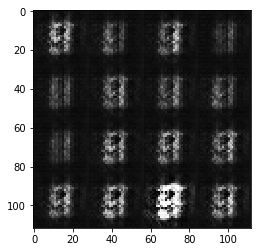

Epoch 1/2... Discriminator Loss: 0.5951... Generator Loss: 1.2698
Epoch 1/2... Discriminator Loss: 1.1892... Generator Loss: 0.4883
Epoch 1/2... Discriminator Loss: 0.5516... Generator Loss: 2.0056
Epoch 1/2... Discriminator Loss: 1.1368... Generator Loss: 3.6982
Epoch 1/2... Discriminator Loss: 0.7122... Generator Loss: 1.8087
Epoch 1/2... Discriminator Loss: 0.3799... Generator Loss: 1.8482
Epoch 1/2... Discriminator Loss: 0.5138... Generator Loss: 1.9300
Epoch 1/2... Discriminator Loss: 0.5645... Generator Loss: 2.8095
Epoch 1/2... Discriminator Loss: 0.4082... Generator Loss: 2.1076
Epoch 1/2... Discriminator Loss: 0.8123... Generator Loss: 1.2135


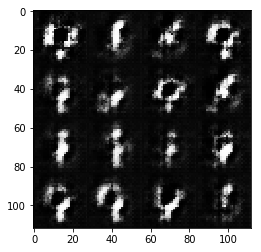

Epoch 1/2... Discriminator Loss: 0.7713... Generator Loss: 0.7920
Epoch 1/2... Discriminator Loss: 1.4751... Generator Loss: 0.4002
Epoch 1/2... Discriminator Loss: 1.6795... Generator Loss: 0.3040
Epoch 1/2... Discriminator Loss: 0.8535... Generator Loss: 0.9307
Epoch 1/2... Discriminator Loss: 0.7740... Generator Loss: 1.1590
Epoch 1/2... Discriminator Loss: 0.7080... Generator Loss: 1.0125
Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 0.6531
Epoch 1/2... Discriminator Loss: 1.0835... Generator Loss: 0.5614
Epoch 1/2... Discriminator Loss: 1.1293... Generator Loss: 2.5054
Epoch 1/2... Discriminator Loss: 0.9112... Generator Loss: 2.5251


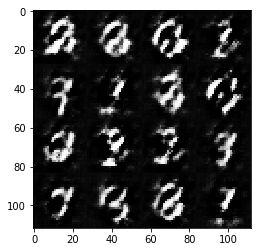

Epoch 1/2... Discriminator Loss: 0.8052... Generator Loss: 1.9354
Epoch 1/2... Discriminator Loss: 1.4620... Generator Loss: 0.3617
Epoch 1/2... Discriminator Loss: 1.2843... Generator Loss: 0.4209
Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 2.3168
Epoch 1/2... Discriminator Loss: 0.6915... Generator Loss: 1.0245
Epoch 1/2... Discriminator Loss: 1.6910... Generator Loss: 0.2941
Epoch 1/2... Discriminator Loss: 1.1416... Generator Loss: 0.5589
Epoch 1/2... Discriminator Loss: 1.3386... Generator Loss: 3.3525
Epoch 1/2... Discriminator Loss: 1.1021... Generator Loss: 0.5393
Epoch 1/2... Discriminator Loss: 0.7676... Generator Loss: 0.9004


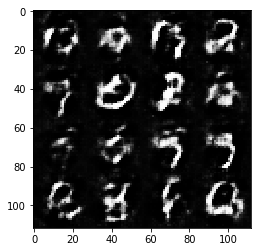

Epoch 1/2... Discriminator Loss: 1.8332... Generator Loss: 0.2132
Epoch 1/2... Discriminator Loss: 0.8430... Generator Loss: 0.8913
Epoch 1/2... Discriminator Loss: 1.2193... Generator Loss: 0.4506
Epoch 1/2... Discriminator Loss: 0.7457... Generator Loss: 0.9985
Epoch 1/2... Discriminator Loss: 1.0846... Generator Loss: 2.6232
Epoch 1/2... Discriminator Loss: 0.7628... Generator Loss: 1.0725
Epoch 1/2... Discriminator Loss: 1.0773... Generator Loss: 2.0013
Epoch 1/2... Discriminator Loss: 0.9174... Generator Loss: 1.5347
Epoch 1/2... Discriminator Loss: 0.8452... Generator Loss: 1.2110
Epoch 1/2... Discriminator Loss: 0.9241... Generator Loss: 1.0239


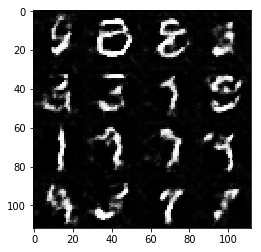

Epoch 1/2... Discriminator Loss: 1.3729... Generator Loss: 0.3800
Epoch 1/2... Discriminator Loss: 0.9612... Generator Loss: 0.6466
Epoch 1/2... Discriminator Loss: 0.8037... Generator Loss: 0.8319
Epoch 1/2... Discriminator Loss: 0.9740... Generator Loss: 2.3457
Epoch 1/2... Discriminator Loss: 0.9074... Generator Loss: 0.9945
Epoch 1/2... Discriminator Loss: 0.9010... Generator Loss: 0.7876
Epoch 1/2... Discriminator Loss: 0.9420... Generator Loss: 1.4709
Epoch 1/2... Discriminator Loss: 1.3342... Generator Loss: 0.4180
Epoch 1/2... Discriminator Loss: 1.3450... Generator Loss: 0.3914
Epoch 1/2... Discriminator Loss: 0.8569... Generator Loss: 0.9235


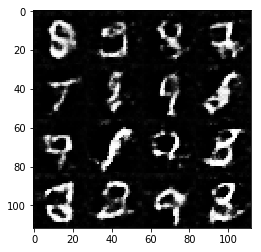

Epoch 1/2... Discriminator Loss: 0.8241... Generator Loss: 1.4901
Epoch 1/2... Discriminator Loss: 1.1404... Generator Loss: 0.5027
Epoch 1/2... Discriminator Loss: 2.6964... Generator Loss: 3.3436
Epoch 1/2... Discriminator Loss: 0.8780... Generator Loss: 1.0473
Epoch 1/2... Discriminator Loss: 1.0025... Generator Loss: 1.7008
Epoch 1/2... Discriminator Loss: 1.1676... Generator Loss: 0.4939
Epoch 1/2... Discriminator Loss: 1.1414... Generator Loss: 0.5086
Epoch 1/2... Discriminator Loss: 1.6107... Generator Loss: 0.2737
Epoch 1/2... Discriminator Loss: 1.1192... Generator Loss: 0.8306
Epoch 1/2... Discriminator Loss: 0.9986... Generator Loss: 1.2192


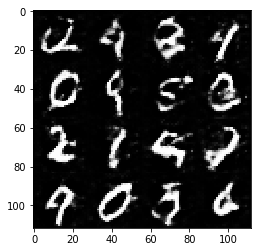

Epoch 1/2... Discriminator Loss: 1.0535... Generator Loss: 0.5867
Epoch 1/2... Discriminator Loss: 0.8505... Generator Loss: 1.6831
Epoch 1/2... Discriminator Loss: 0.9624... Generator Loss: 0.8493
Epoch 1/2... Discriminator Loss: 1.2814... Generator Loss: 0.4098
Epoch 1/2... Discriminator Loss: 0.8563... Generator Loss: 1.1478
Epoch 1/2... Discriminator Loss: 1.4334... Generator Loss: 1.4704
Epoch 1/2... Discriminator Loss: 1.1516... Generator Loss: 0.6220
Epoch 1/2... Discriminator Loss: 1.0086... Generator Loss: 0.6001
Epoch 1/2... Discriminator Loss: 1.0813... Generator Loss: 0.5947
Epoch 1/2... Discriminator Loss: 0.8172... Generator Loss: 1.2121


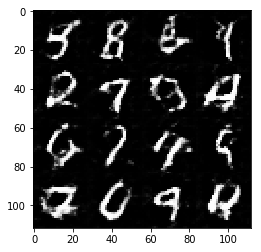

Epoch 1/2... Discriminator Loss: 1.1430... Generator Loss: 1.5818
Epoch 1/2... Discriminator Loss: 1.0154... Generator Loss: 1.1613
Epoch 1/2... Discriminator Loss: 1.3120... Generator Loss: 0.4009
Epoch 1/2... Discriminator Loss: 1.2556... Generator Loss: 0.4510
Epoch 1/2... Discriminator Loss: 0.9672... Generator Loss: 0.6159
Epoch 1/2... Discriminator Loss: 1.4432... Generator Loss: 0.3320
Epoch 1/2... Discriminator Loss: 0.8374... Generator Loss: 1.0864
Epoch 1/2... Discriminator Loss: 1.0563... Generator Loss: 1.1070
Epoch 1/2... Discriminator Loss: 1.0858... Generator Loss: 1.1421
Epoch 1/2... Discriminator Loss: 0.8925... Generator Loss: 0.9241


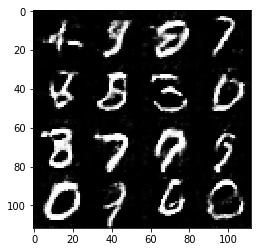

Epoch 1/2... Discriminator Loss: 1.0313... Generator Loss: 1.3930
Epoch 1/2... Discriminator Loss: 1.6295... Generator Loss: 0.2614
Epoch 1/2... Discriminator Loss: 1.0614... Generator Loss: 0.7280
Epoch 2/2... Discriminator Loss: 1.0579... Generator Loss: 1.1806
Epoch 2/2... Discriminator Loss: 0.9211... Generator Loss: 0.9162
Epoch 2/2... Discriminator Loss: 1.0525... Generator Loss: 1.5110
Epoch 2/2... Discriminator Loss: 1.0989... Generator Loss: 0.5304
Epoch 2/2... Discriminator Loss: 0.9708... Generator Loss: 0.6997
Epoch 2/2... Discriminator Loss: 1.0786... Generator Loss: 1.8249
Epoch 2/2... Discriminator Loss: 0.8159... Generator Loss: 1.0813


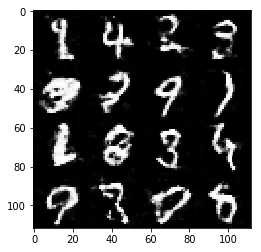

Epoch 2/2... Discriminator Loss: 0.9428... Generator Loss: 0.6121
Epoch 2/2... Discriminator Loss: 0.8958... Generator Loss: 0.7568
Epoch 2/2... Discriminator Loss: 0.8521... Generator Loss: 1.5157
Epoch 2/2... Discriminator Loss: 0.9768... Generator Loss: 0.5932
Epoch 2/2... Discriminator Loss: 0.5633... Generator Loss: 1.3625
Epoch 2/2... Discriminator Loss: 1.2063... Generator Loss: 1.4360
Epoch 2/2... Discriminator Loss: 1.0418... Generator Loss: 1.4353
Epoch 2/2... Discriminator Loss: 1.3732... Generator Loss: 0.3522
Epoch 2/2... Discriminator Loss: 1.0529... Generator Loss: 0.5970
Epoch 2/2... Discriminator Loss: 1.2389... Generator Loss: 0.4713


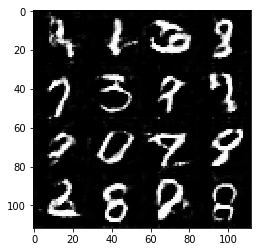

Epoch 2/2... Discriminator Loss: 1.0644... Generator Loss: 0.6944
Epoch 2/2... Discriminator Loss: 1.1073... Generator Loss: 0.5118
Epoch 2/2... Discriminator Loss: 0.9687... Generator Loss: 1.6023
Epoch 2/2... Discriminator Loss: 0.8490... Generator Loss: 0.9234
Epoch 2/2... Discriminator Loss: 1.0360... Generator Loss: 0.9502
Epoch 2/2... Discriminator Loss: 1.1641... Generator Loss: 0.4886
Epoch 2/2... Discriminator Loss: 1.3379... Generator Loss: 0.3890
Epoch 2/2... Discriminator Loss: 1.3359... Generator Loss: 0.3925
Epoch 2/2... Discriminator Loss: 0.9874... Generator Loss: 0.7994
Epoch 2/2... Discriminator Loss: 0.9575... Generator Loss: 1.0259


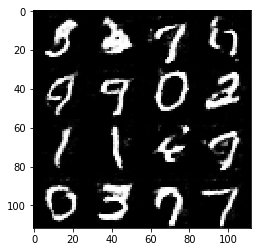

Epoch 2/2... Discriminator Loss: 0.9832... Generator Loss: 0.9413
Epoch 2/2... Discriminator Loss: 1.3385... Generator Loss: 0.3754
Epoch 2/2... Discriminator Loss: 1.2893... Generator Loss: 0.4475
Epoch 2/2... Discriminator Loss: 1.5619... Generator Loss: 0.2938
Epoch 2/2... Discriminator Loss: 1.0821... Generator Loss: 0.6135
Epoch 2/2... Discriminator Loss: 1.6812... Generator Loss: 0.2400
Epoch 2/2... Discriminator Loss: 1.1096... Generator Loss: 1.1533
Epoch 2/2... Discriminator Loss: 0.8713... Generator Loss: 0.9836
Epoch 2/2... Discriminator Loss: 1.2143... Generator Loss: 0.4312
Epoch 2/2... Discriminator Loss: 0.8295... Generator Loss: 1.5370


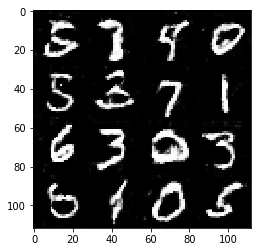

Epoch 2/2... Discriminator Loss: 1.3496... Generator Loss: 1.7795
Epoch 2/2... Discriminator Loss: 1.0695... Generator Loss: 0.7363
Epoch 2/2... Discriminator Loss: 1.0967... Generator Loss: 0.5644
Epoch 2/2... Discriminator Loss: 0.7747... Generator Loss: 1.0578
Epoch 2/2... Discriminator Loss: 0.7071... Generator Loss: 1.5506
Epoch 2/2... Discriminator Loss: 1.0982... Generator Loss: 0.6999
Epoch 2/2... Discriminator Loss: 0.9225... Generator Loss: 0.8434
Epoch 2/2... Discriminator Loss: 1.2012... Generator Loss: 0.7693
Epoch 2/2... Discriminator Loss: 1.1194... Generator Loss: 0.8232
Epoch 2/2... Discriminator Loss: 0.9549... Generator Loss: 0.7151


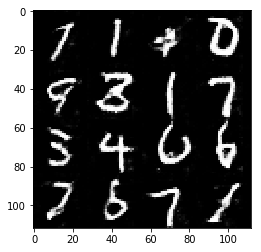

Epoch 2/2... Discriminator Loss: 0.9563... Generator Loss: 1.0341
Epoch 2/2... Discriminator Loss: 1.0619... Generator Loss: 0.5457
Epoch 2/2... Discriminator Loss: 1.7175... Generator Loss: 0.2558
Epoch 2/2... Discriminator Loss: 1.6025... Generator Loss: 0.2710
Epoch 2/2... Discriminator Loss: 0.8346... Generator Loss: 0.8207
Epoch 2/2... Discriminator Loss: 1.0292... Generator Loss: 0.8125
Epoch 2/2... Discriminator Loss: 1.0985... Generator Loss: 0.8121
Epoch 2/2... Discriminator Loss: 1.1120... Generator Loss: 0.5672
Epoch 2/2... Discriminator Loss: 1.0052... Generator Loss: 1.3496
Epoch 2/2... Discriminator Loss: 0.9454... Generator Loss: 1.2879


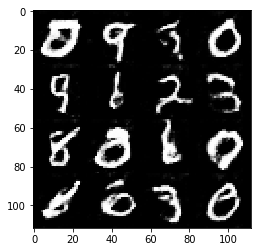

Epoch 2/2... Discriminator Loss: 0.8178... Generator Loss: 0.8987
Epoch 2/2... Discriminator Loss: 0.9728... Generator Loss: 0.6920
Epoch 2/2... Discriminator Loss: 1.2970... Generator Loss: 0.4428
Epoch 2/2... Discriminator Loss: 1.0005... Generator Loss: 0.6745
Epoch 2/2... Discriminator Loss: 1.1458... Generator Loss: 0.5514
Epoch 2/2... Discriminator Loss: 1.2318... Generator Loss: 0.4482
Epoch 2/2... Discriminator Loss: 1.0483... Generator Loss: 1.2327
Epoch 2/2... Discriminator Loss: 1.1378... Generator Loss: 0.4883
Epoch 2/2... Discriminator Loss: 0.8360... Generator Loss: 0.9930
Epoch 2/2... Discriminator Loss: 0.9023... Generator Loss: 1.1696


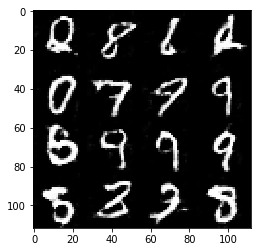

Epoch 2/2... Discriminator Loss: 1.3762... Generator Loss: 0.3662
Epoch 2/2... Discriminator Loss: 1.1833... Generator Loss: 0.5454
Epoch 2/2... Discriminator Loss: 1.0890... Generator Loss: 0.5817
Epoch 2/2... Discriminator Loss: 1.8370... Generator Loss: 0.2079
Epoch 2/2... Discriminator Loss: 1.1149... Generator Loss: 0.6562
Epoch 2/2... Discriminator Loss: 1.4869... Generator Loss: 0.3237
Epoch 2/2... Discriminator Loss: 1.0650... Generator Loss: 0.5656
Epoch 2/2... Discriminator Loss: 0.9137... Generator Loss: 1.1120
Epoch 2/2... Discriminator Loss: 0.6939... Generator Loss: 1.2128
Epoch 2/2... Discriminator Loss: 1.0400... Generator Loss: 2.4026


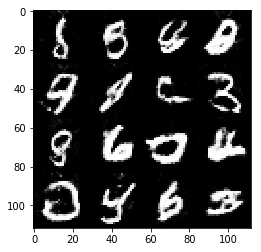

Epoch 2/2... Discriminator Loss: 1.0246... Generator Loss: 0.8856
Epoch 2/2... Discriminator Loss: 1.0765... Generator Loss: 0.6623
Epoch 2/2... Discriminator Loss: 0.9322... Generator Loss: 0.8298
Epoch 2/2... Discriminator Loss: 1.3725... Generator Loss: 0.3527
Epoch 2/2... Discriminator Loss: 1.1358... Generator Loss: 0.5306
Epoch 2/2... Discriminator Loss: 1.1443... Generator Loss: 0.5433
Epoch 2/2... Discriminator Loss: 1.6768... Generator Loss: 0.2623
Epoch 2/2... Discriminator Loss: 0.9235... Generator Loss: 1.1350
Epoch 2/2... Discriminator Loss: 1.2171... Generator Loss: 0.4315
Epoch 2/2... Discriminator Loss: 0.8602... Generator Loss: 0.9449


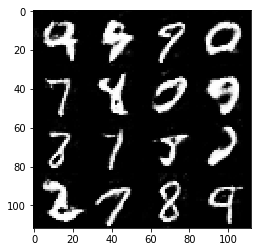

Epoch 2/2... Discriminator Loss: 1.2687... Generator Loss: 0.4294
Epoch 2/2... Discriminator Loss: 3.0037... Generator Loss: 3.9121
Epoch 2/2... Discriminator Loss: 0.9923... Generator Loss: 1.2499
Epoch 2/2... Discriminator Loss: 0.9886... Generator Loss: 0.7505
Epoch 2/2... Discriminator Loss: 0.9301... Generator Loss: 0.7491
Epoch 2/2... Discriminator Loss: 1.0904... Generator Loss: 0.6377
Epoch 2/2... Discriminator Loss: 1.1368... Generator Loss: 0.6172


In [51]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5849... Generator Loss: 9.0202
Epoch 1/1... Discriminator Loss: 0.0245... Generator Loss: 6.2661
Epoch 1/1... Discriminator Loss: 0.1269... Generator Loss: 8.1659
Epoch 1/1... Discriminator Loss: 1.8065... Generator Loss: 17.2571
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 0.2317... Generator Loss: 4.9375
Epoch 1/1... Discriminator Loss: 0.0435... Generator Loss: 4.6907
Epoch 1/1... Discriminator Loss: 0.2939... Generator Loss: 1.6399
Epoch 1/1... Discriminator Loss: 0.5769... Generator Loss: 1.3003
Epoch 1/1... Discriminator Loss: 0.4144... Generator Loss: 4.5333


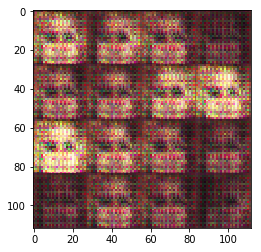

Epoch 1/1... Discriminator Loss: 0.9973... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 2.7078... Generator Loss: 7.1047
Epoch 1/1... Discriminator Loss: 2.4541... Generator Loss: 6.5595
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 2.4194
Epoch 1/1... Discriminator Loss: 1.0259... Generator Loss: 1.4422
Epoch 1/1... Discriminator Loss: 0.5463... Generator Loss: 1.2771
Epoch 1/1... Discriminator Loss: 0.7288... Generator Loss: 1.2235
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.4278
Epoch 1/1... Discriminator Loss: 0.4951... Generator Loss: 2.8991


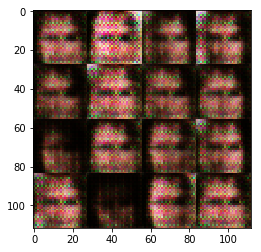

Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 1.1042
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 1.2581
Epoch 1/1... Discriminator Loss: 0.8428... Generator Loss: 3.0309
Epoch 1/1... Discriminator Loss: 0.5705... Generator Loss: 1.8363
Epoch 1/1... Discriminator Loss: 0.8824... Generator Loss: 1.2782
Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.4295
Epoch 1/1... Discriminator Loss: 1.1627... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.5177
Epoch 1/1... Discriminator Loss: 0.8532... Generator Loss: 0.8371


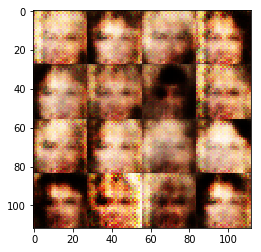

Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.4609
Epoch 1/1... Discriminator Loss: 0.7003... Generator Loss: 1.6648
Epoch 1/1... Discriminator Loss: 2.6317... Generator Loss: 0.1392
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 2.0156
Epoch 1/1... Discriminator Loss: 1.5667... Generator Loss: 0.3370
Epoch 1/1... Discriminator Loss: 0.7125... Generator Loss: 2.1331
Epoch 1/1... Discriminator Loss: 1.8149... Generator Loss: 4.3328
Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 0.7848... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.5208


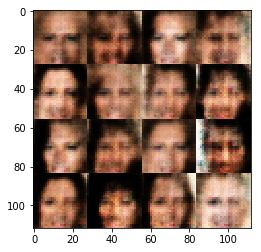

Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.4361
Epoch 1/1... Discriminator Loss: 0.5599... Generator Loss: 1.1773
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 2.8383
Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 0.5724... Generator Loss: 1.5152


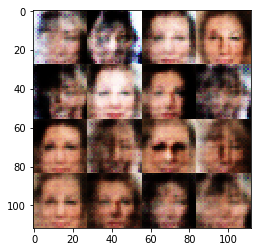

Epoch 1/1... Discriminator Loss: 1.6153... Generator Loss: 0.2868
Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 1.7348
Epoch 1/1... Discriminator Loss: 0.6816... Generator Loss: 1.0959
Epoch 1/1... Discriminator Loss: 0.8264... Generator Loss: 0.9302
Epoch 1/1... Discriminator Loss: 0.5520... Generator Loss: 1.3366
Epoch 1/1... Discriminator Loss: 0.6952... Generator Loss: 1.6082
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 1.9385
Epoch 1/1... Discriminator Loss: 0.8985... Generator Loss: 0.8179


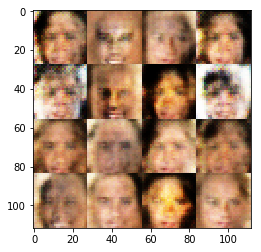

Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 0.9540
Epoch 1/1... Discriminator Loss: 0.9419... Generator Loss: 1.0637
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 0.7064... Generator Loss: 2.4664
Epoch 1/1... Discriminator Loss: 0.6882... Generator Loss: 1.1782
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 1.7028
Epoch 1/1... Discriminator Loss: 2.1843... Generator Loss: 0.1956
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.4788
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 0.5834


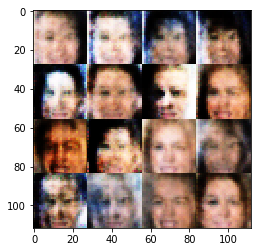

Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.3987
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 2.7118
Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 2.0212
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 1.9488
Epoch 1/1... Discriminator Loss: 0.7122... Generator Loss: 1.5517
Epoch 1/1... Discriminator Loss: 0.8379... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 2.5715
Epoch 1/1... Discriminator Loss: 2.3197... Generator Loss: 3.6140
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 1.4788


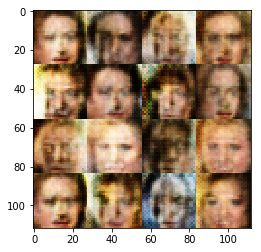

Epoch 1/1... Discriminator Loss: 0.9381... Generator Loss: 1.3052
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 1.0335
Epoch 1/1... Discriminator Loss: 0.8542... Generator Loss: 1.0009
Epoch 1/1... Discriminator Loss: 0.8004... Generator Loss: 1.2584
Epoch 1/1... Discriminator Loss: 1.5860... Generator Loss: 0.3219
Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 1.7766
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.3548
Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 1.1233
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 0.5207
Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 2.6019


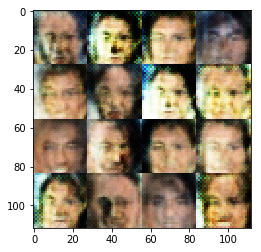

Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 0.6888... Generator Loss: 2.0264
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 0.7357... Generator Loss: 1.0253
Epoch 1/1... Discriminator Loss: 1.8570... Generator Loss: 1.7527
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 1.3787
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 0.6692


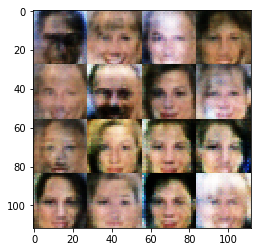

Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 2.5486
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 1.1908
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 0.9688... Generator Loss: 1.7058
Epoch 1/1... Discriminator Loss: 0.7718... Generator Loss: 1.5788
Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 1.1191
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.4075
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 1.7363
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 0.8747


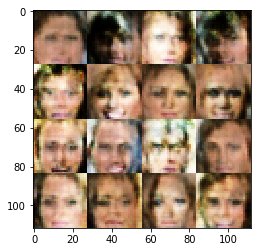

Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 0.8339... Generator Loss: 0.9433
Epoch 1/1... Discriminator Loss: 0.7737... Generator Loss: 1.2625
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 1.4055
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.4480
Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 1.7750
Epoch 1/1... Discriminator Loss: 0.7872... Generator Loss: 2.2729
Epoch 1/1... Discriminator Loss: 0.7238... Generator Loss: 1.2242
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 0.8019


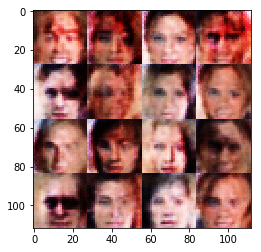

Epoch 1/1... Discriminator Loss: 0.9124... Generator Loss: 0.9158
Epoch 1/1... Discriminator Loss: 0.7948... Generator Loss: 1.2749
Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 1.0677
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.3904
Epoch 1/1... Discriminator Loss: 0.6949... Generator Loss: 1.2942
Epoch 1/1... Discriminator Loss: 0.7552... Generator Loss: 1.0390
Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 0.8576
Epoch 1/1... Discriminator Loss: 1.5352... Generator Loss: 0.3471
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 2.3187
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 0.6366


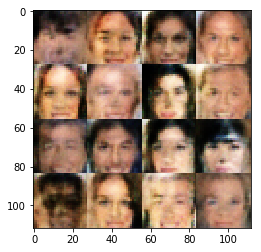

Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.3900
Epoch 1/1... Discriminator Loss: 0.6893... Generator Loss: 1.7219
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 1.5788
Epoch 1/1... Discriminator Loss: 1.7364... Generator Loss: 0.2833
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.4078
Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 0.9738... Generator Loss: 1.4845
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 0.3591
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.5638


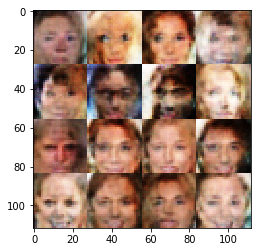

Epoch 1/1... Discriminator Loss: 0.8982... Generator Loss: 1.9608
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 1.7698
Epoch 1/1... Discriminator Loss: 0.5938... Generator Loss: 1.7125
Epoch 1/1... Discriminator Loss: 0.8003... Generator Loss: 1.4762
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 1.6812
Epoch 1/1... Discriminator Loss: 0.8920... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.6023... Generator Loss: 0.3217
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 1.4929
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 1.0287


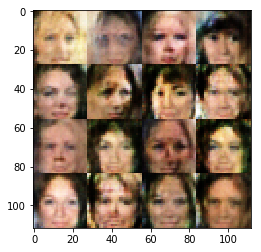

Epoch 1/1... Discriminator Loss: 0.8825... Generator Loss: 1.4860
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 1.5736
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 0.8258... Generator Loss: 1.4999
Epoch 1/1... Discriminator Loss: 1.0941... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 1.2354
Epoch 1/1... Discriminator Loss: 0.9102... Generator Loss: 1.1084
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 1.9451
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 0.5484
Epoch 1/1... Discriminator Loss: 0.7810... Generator Loss: 2.9982


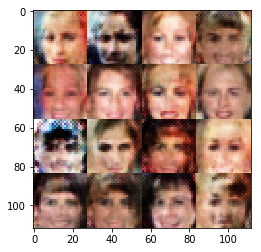

Epoch 1/1... Discriminator Loss: 0.9790... Generator Loss: 1.0391
Epoch 1/1... Discriminator Loss: 0.7891... Generator Loss: 1.8473
Epoch 1/1... Discriminator Loss: 0.7763... Generator Loss: 1.0810
Epoch 1/1... Discriminator Loss: 0.7527... Generator Loss: 1.1775
Epoch 1/1... Discriminator Loss: 0.7194... Generator Loss: 1.2689
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 1.0480
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.3354
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.3860
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 1.0463
Epoch 1/1... Discriminator Loss: 1.0461... Generator Loss: 0.6389


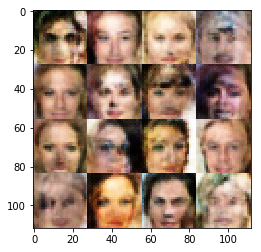

Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.4172
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 1.1740
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.4539
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.4095
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.5349
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 2.3056
Epoch 1/1... Discriminator Loss: 0.5964... Generator Loss: 1.3493
Epoch 1/1... Discriminator Loss: 1.2343... Generator Loss: 0.5068


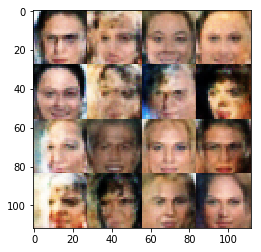

Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 1.0040
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.5443
Epoch 1/1... Discriminator Loss: 0.7787... Generator Loss: 1.2437
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.4719
Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.5204
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.4271
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 0.5213
Epoch 1/1... Discriminator Loss: 0.8439... Generator Loss: 1.4776
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.4812


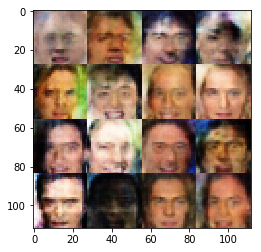

Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.5269
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.3881
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.3960
Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 2.4832
Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 1.3930
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.3565
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 0.8746
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 1.2289
Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 1.0386


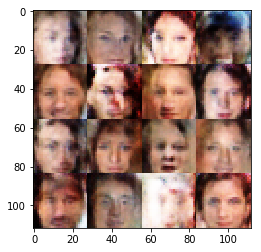

Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 1.7860
Epoch 1/1... Discriminator Loss: 0.8105... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 0.6592... Generator Loss: 1.8332
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 1.7846
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.4501
Epoch 1/1... Discriminator Loss: 0.8169... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 0.8684... Generator Loss: 1.2468
Epoch 1/1... Discriminator Loss: 0.7139... Generator Loss: 1.5322
Epoch 1/1... Discriminator Loss: 1.7083... Generator Loss: 1.8402
Epoch 1/1... Discriminator Loss: 0.9996... Generator Loss: 0.6702


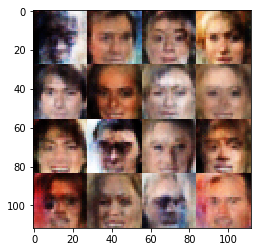

Epoch 1/1... Discriminator Loss: 0.6994... Generator Loss: 1.5519
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.4670
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.4674
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.5079
Epoch 1/1... Discriminator Loss: 0.8648... Generator Loss: 1.1601
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 1.3078
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 0.9369... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 0.6106... Generator Loss: 1.4204
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 1.6766


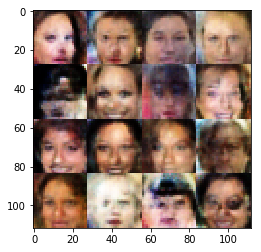

Epoch 1/1... Discriminator Loss: 0.8193... Generator Loss: 1.8144
Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 1.8936
Epoch 1/1... Discriminator Loss: 0.9356... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 0.8454... Generator Loss: 1.0923
Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 0.7678... Generator Loss: 1.7589
Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 1.5933
Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 1.1958
Epoch 1/1... Discriminator Loss: 0.5457... Generator Loss: 2.1970
Epoch 1/1... Discriminator Loss: 0.6686... Generator Loss: 2.1940


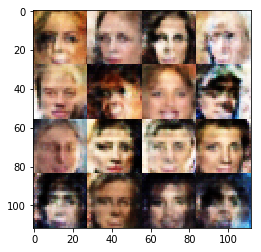

Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.5147
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.3879
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.4244
Epoch 1/1... Discriminator Loss: 1.0694... Generator Loss: 0.5772
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 1.2003
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 1.7065
Epoch 1/1... Discriminator Loss: 0.8140... Generator Loss: 1.5268
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 0.6800... Generator Loss: 1.2903


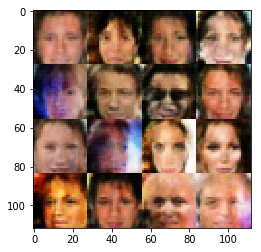

Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 0.5745
Epoch 1/1... Discriminator Loss: 1.5280... Generator Loss: 0.3125
Epoch 1/1... Discriminator Loss: 0.9749... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 0.9322... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 1.6857
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.5086
Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 1.0530
Epoch 1/1... Discriminator Loss: 0.9072... Generator Loss: 1.7266
Epoch 1/1... Discriminator Loss: 0.8316... Generator Loss: 1.1510
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.4134


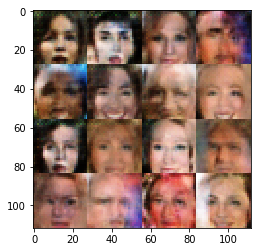

Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 0.5637
Epoch 1/1... Discriminator Loss: 0.5140... Generator Loss: 1.7478
Epoch 1/1... Discriminator Loss: 0.8959... Generator Loss: 1.9751
Epoch 1/1... Discriminator Loss: 0.7478... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.3965
Epoch 1/1... Discriminator Loss: 0.7885... Generator Loss: 0.9524
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 1.1934
Epoch 1/1... Discriminator Loss: 1.0231... Generator Loss: 1.5829
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 1.0216


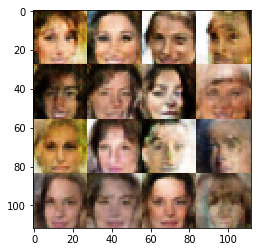

Epoch 1/1... Discriminator Loss: 0.7278... Generator Loss: 1.9226
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.4192
Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 1.0868
Epoch 1/1... Discriminator Loss: 0.6329... Generator Loss: 1.4686
Epoch 1/1... Discriminator Loss: 0.7198... Generator Loss: 1.2431
Epoch 1/1... Discriminator Loss: 1.1016... Generator Loss: 2.2721
Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 2.1441
Epoch 1/1... Discriminator Loss: 0.5723... Generator Loss: 1.7750
Epoch 1/1... Discriminator Loss: 0.8783... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 1.9085


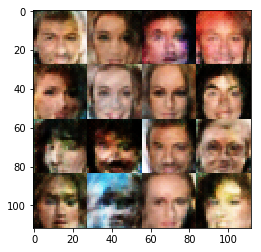

Epoch 1/1... Discriminator Loss: 1.5335... Generator Loss: 0.3022
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.4924
Epoch 1/1... Discriminator Loss: 0.6441... Generator Loss: 1.0937
Epoch 1/1... Discriminator Loss: 1.7475... Generator Loss: 0.2533
Epoch 1/1... Discriminator Loss: 0.9027... Generator Loss: 1.2637
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.3639
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 2.0377
Epoch 1/1... Discriminator Loss: 1.0582... Generator Loss: 1.3557
Epoch 1/1... Discriminator Loss: 0.6056... Generator Loss: 1.6519
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 1.9973


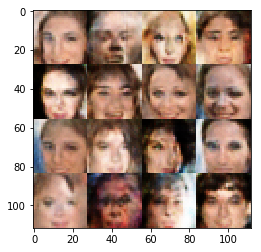

Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 1.5272
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 1.0713
Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 0.5751... Generator Loss: 1.3300
Epoch 1/1... Discriminator Loss: 1.1755... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.4471
Epoch 1/1... Discriminator Loss: 1.6140... Generator Loss: 0.2918
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.4453
Epoch 1/1... Discriminator Loss: 0.7021... Generator Loss: 2.7442
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 1.7240


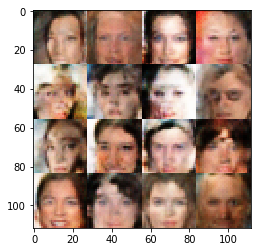

Epoch 1/1... Discriminator Loss: 1.0671... Generator Loss: 0.9926
Epoch 1/1... Discriminator Loss: 0.8207... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 0.9574... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 0.5798
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.5021
Epoch 1/1... Discriminator Loss: 0.8233... Generator Loss: 1.4617
Epoch 1/1... Discriminator Loss: 0.6558... Generator Loss: 1.6727
Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.4852
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.7768


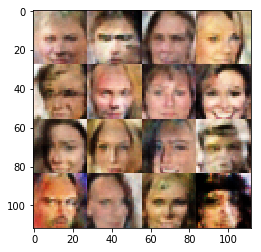

Epoch 1/1... Discriminator Loss: 0.7729... Generator Loss: 1.0528
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 2.5570
Epoch 1/1... Discriminator Loss: 1.1337... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 0.9734... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 0.6560... Generator Loss: 2.5501
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 0.8073... Generator Loss: 1.1652
Epoch 1/1... Discriminator Loss: 0.7219... Generator Loss: 1.8349
Epoch 1/1... Discriminator Loss: 1.2245... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 0.6505... Generator Loss: 0.9897


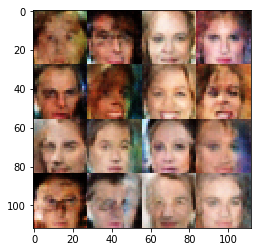

Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 0.8069
Epoch 1/1... Discriminator Loss: 1.5251... Generator Loss: 0.3250
Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.3836
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 0.6831
Epoch 1/1... Discriminator Loss: 0.8321... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 0.7855... Generator Loss: 1.5758


In [52]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.